#Problem 2: Dimensionality reduction
Consider a dataset where M neurons are recorded during repeated trials of a reach task. The resulting data is a number of matrices (one per trial) that is N ×T (number of neurons by time - in 1 ms bins) where Xit represents the number of spikes for neuron i during the time-bin t. This problem will consider the dimensionality reduction approach of finding the underlying patterns of neural activity common across trials. Specifically we will first look at standard PCA before and after processing (to highlight the benefit of priors over spike-rates). We will then look at applying an external package that finds smooth spike-rates underlying the neural activity automatically (Gaussian Process Factor Analysis).

##Part A
Load the data from sample dat.mat. Compute the peristimulus time histogram (PSTH) of the data. Plot the PSTHs and note any trends. Now pre-process the data by using a Gaussian Process (GP) prior to smooth the data. A GP prior smooths the data by creating a correlation structure that makes nearby points in time have similar values. Specifically, if we treat each neuron’s PSTH as xn, which is a T-dimensional vector, the prior distribution is xn ∼ N(0,K),
where the covariance matrix K is defined as Kij = A ∗e−(ti−tj)2/l. Use the same approach as Problem 1 to get an estimate of the smoothed PSTH per neuron. Compare the two sets of PSTHs visually and remark on any details you notice. TIP: This computation might take a minute to run depending on your computer. Test on one neuron first before running on all the neurons (this is a good habit to get into with computational work regardless!)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


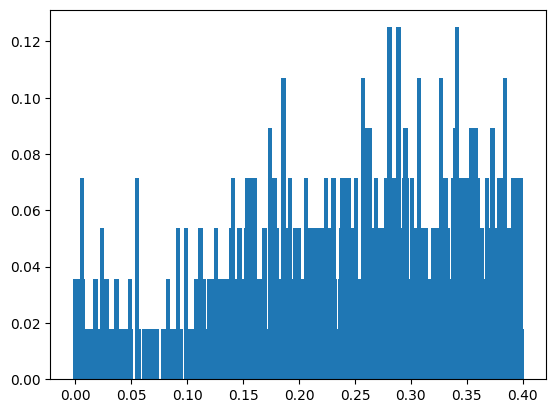

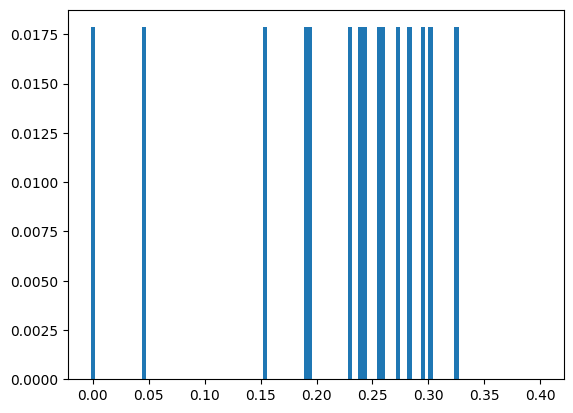

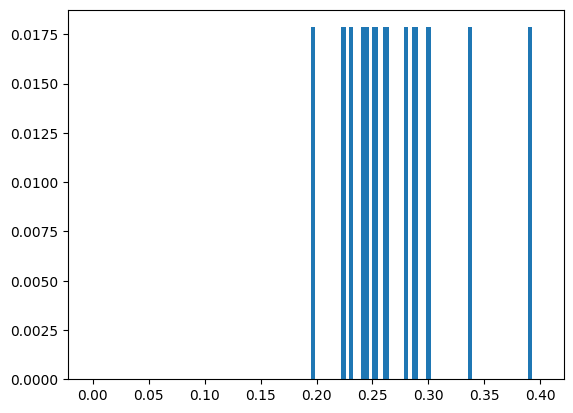

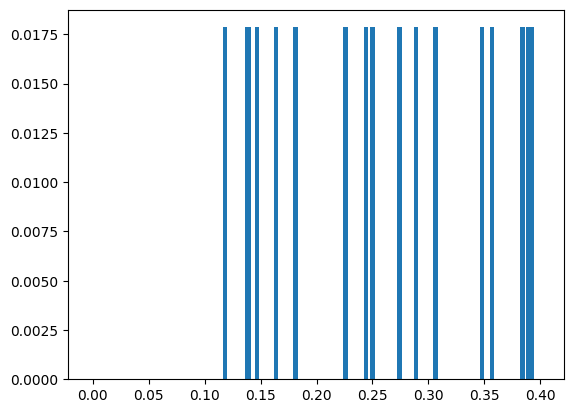

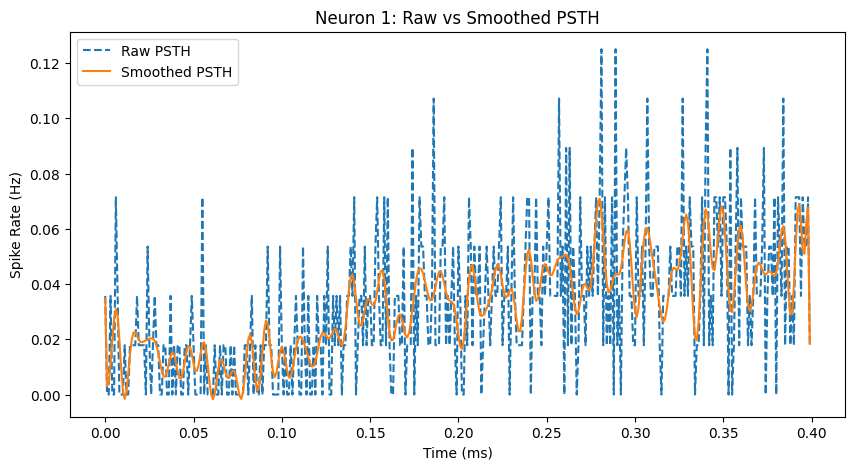

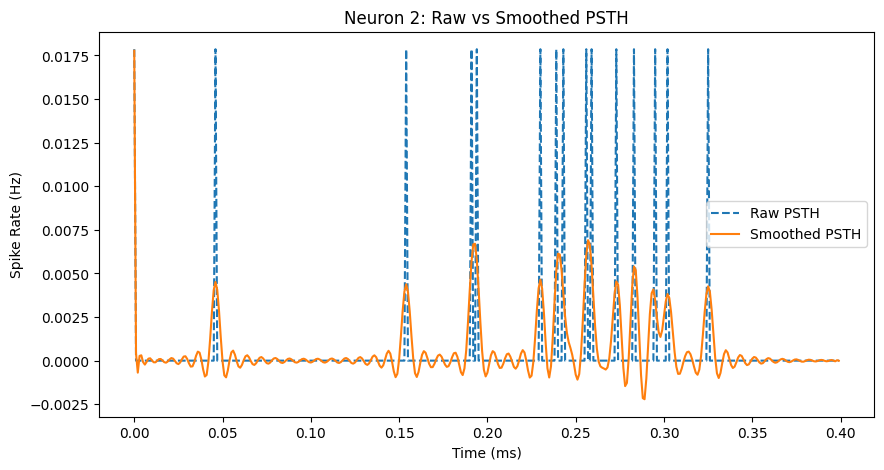

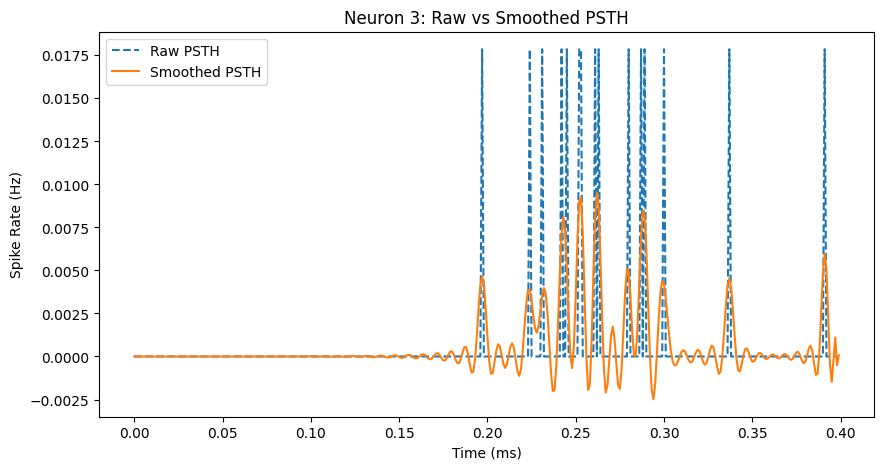

In [ ]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

# Find the file in google drive
drive.mount('/content/drive')
file = "/content/drive/MyDrive/Neural_Signals_and_Computation_HW2/sample_dat.mat"

import scipy.io as sio
mat_contents = sio.loadmat(file)
data_trials = mat_contents['dat'][0]

## Make Perstimulus Time Histograms
raw_psth = []
smooth_psth = []
bins = np.arange(0, 0.4 + 0.001, 0.001)
for i in range(len(data_trials[0][1])):
  total = []
  for trials in data_trials:
    # This is number of spikes for Neuron i at time bin n (1 msec bins)
    n1 = []
    for j in range(len(trials[1][i])):
      if trials[1][0][j] * 0.001 != 0:
        for k in range(trials[1][i][j]):
          n1.append(0.001 * j)
      elif j == 0 and trials[1][i][j] > 0:
        for k in range(trials[1][i][j]):
          n1.append(0.001 * j)
    if total is not None:
      total += n1
    else:
      total = n1

  y = np.histogram(total, bins=bins)[0] / len(data_trials)
  raw_psth.append(y)

  # Print 3 PSTH for example
  if i < 3:
    plt.bar(bins[:-1], y, width=0.004)
    plt.show()

# Conduct Gaussian Process
raw_psth = np.array(raw_psth)
time_bins = bins[:-1]

kernel = ConstantKernel(1, (1e-2, 1e2)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

import warnings
warnings.filterwarnings("ignore")

smoothed_psth = np.zeros_like(raw_psth)
for n in range(raw_psth.shape[0]):
  gp.fit(time_bins[:, np.newaxis], raw_psth[n, :])
  smoothed_psth[n, :] = gp.predict(time_bins[:, np.newaxis])

# Plot the comparison of raw and smoothed PSTHs for a sample neuron
for n in range(3):
  neuron_index = n  # Replace with an index of your choice
  plt.figure(figsize=(10, 5))
  plt.plot(time_bins, raw_psth[neuron_index, :], label='Raw PSTH', linestyle='--')
  plt.plot(time_bins, smoothed_psth[neuron_index, :], label='Smoothed PSTH', linestyle='-')
  plt.xlabel('Time (ms)')
  plt.ylabel('Spike Rate (Hz)')
  plt.title(f'Neuron {neuron_index + 1}: Raw vs Smoothed PSTH')
  plt.legend()
  plt.show()

When plotting the raw PSTHs, it appears that in every case, except for the first neuron, that the firing rates are distributed quite discretely with certain levels of firing at specific times rather than firing continously over time. It could indicate that some neurons fired at specific intervals responding to a certain stimulus or other reaction.

In terms of the raw and smoothed PSTHs, they tend to follow the same overall shape and pattern, with the sharp points of higher spike rate correlating to high hills / spikes in the smoothed case, but the smoothed case has a sort of ringing or 'bounce down' before attentuating the jump to 0 and even goes into the negative slightly after smoothing in some sections.